In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!gcloud config set project g2-tfrecords
!gsutil ls

Updated property [core/project].
gs://g2-gravitational-waves-tfrecords_bucket/


In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
sns.set(font_scale=1.1, rc={
    'figure.figsize': (15, 10),
    'axes.facecolor': 'white',
    'figure.facecolor': 'white',
    'grid.color': '#dddddd',
    'grid.linewidth': 0.5,
    "lines.linewidth": 1.5,
    'text.color': '#333333',
    'xtick.color': '#666666',
    'ytick.color': '#666666'
})
import pandas as pd

# GRAD-CAM

https://keras.io/examples/vision/grad_cam/

In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [ ]:
def build_model_gradcam(size):
    base = efn.EfficientNetB7(input_shape=(size,size,3),weights='imagenet',include_top=False)
    # base = getattr(efn, "EfficientNetB7")(input_shape=(size, size, 3), weights='imagenet', include_top=False)
    x = tf.keras.layers.GlobalAvgPool2D()(base.output)
    
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(1,activation='sigmoid')(x)
    model = tf.keras.Model(inputs=base.input, outputs=x)
    opt = tf.optimizers.SGD(learning_rate=1e-3)
    loss = tf.keras.losses.BinaryCrossentropy() 
    model.compile(optimizer=opt,loss=loss,metrics=['AUC'])
    return model
with strategy.scope():
  grad_cam_model = build_model_gradcam(256)

In [ ]:
grad_cam_model.set_weights(cnn_efn_model.get_weights())

In [ ]:
from gwpy.timeseries import TimeSeries
from gwpy.plot import Plot
import numpy as np
from scipy import signal
from sklearn.preprocessing import MinMaxScaler
from PIL import Image
from matplotlib import pyplot as plt

In [ ]:
def read_file(data):
    d1 = TimeSeries(data[0,:], sample_rate=2048)
    d2 = TimeSeries(data[1,:], sample_rate=2048)
    d3 = TimeSeries(data[2,:], sample_rate=2048)
    return d1, d2, d3

def plot_time_data(d1, d2, d3):
    plot = Plot(d1, d2, d3, separate=True, sharex=True, figsize=[12, 8])
    ax = plot.gca()
    ax.set_xlim(0,2)
    ax.set_xlabel('Time [s]')
    plot.show()

In [ ]:
d1,d2,d3 = read_file(wave)

In [ ]:
wave_image = tf.reshape(wave_image, (1, 256, 256, 3))

In [ ]:
p1, p2, p3 = preprocess(d1, d2, d3)
hq = p1.q_transform(qrange=(16,32), frange=(30,400), logf=True, whiten=False)
fig4 = hq.plot(figsize=[12, 10])
plt.axis('off')
# ax = fig4.gca()
fig4.colorbar(cmap='viridis', label="Normalised Energy")
# ax.grid(False)
# ax.set_yscale('log')
# ax.set_xlabel('Time [s]');

In [ ]:
heatmap = make_gradcam_heatmap(wave_image, grad_cam_model, 'top_activation')

In [ ]:
import matplotlib.cm as cm
def display_gradcam(img, heatmap,alpha, ax):
    # Load the original image
    # img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img * (1 - alpha)
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    plt.imshow(superimposed_img)

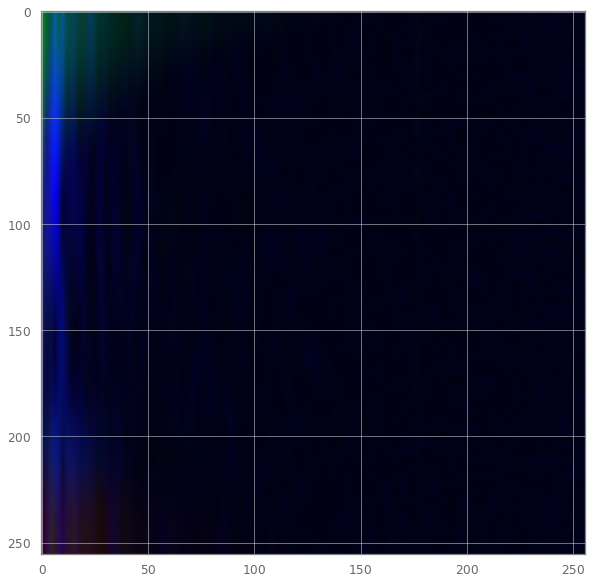

In [ ]:
display_gradcam(tf.reshape(wave_image, (256,256,3)), heatmap, 0.001, ax)
plt.show()

In [ ]:
cnn_efn_model.load_weights('/content/drive/MyDrive/G2/Models/cnn_efnb7/Fold_0.h5')

In [ ]:
from google.colab.patches import cv2_imshow

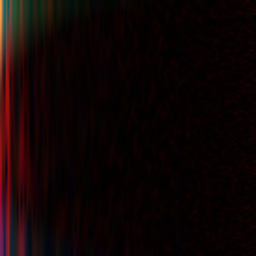

In [ ]:
cv2_imshow(wave_array)

In [ ]:
wave_array = wave_image.numpy()

In [ ]:
wave_array *= (255.0/wave_array.max())

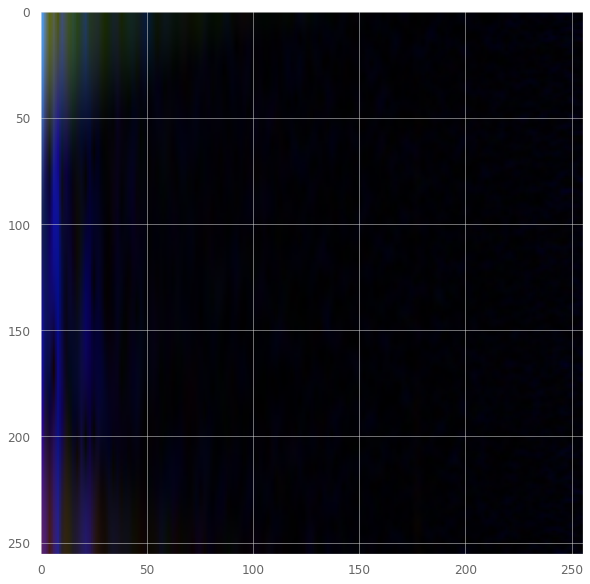

In [ ]:
plt.imshow(wave_array.astype(np.uint8))

In [2]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()